In [ ]:
import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TextClassificationPipeline


In [ ]:
import transformers
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve


In [ ]:
import torch.optim
from transformers import get_linear_schedule_with_warmup

In [ ]:
# check GPU
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla T4


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/My Drive/Colab Notebooks/clean_data.csv' #veriseti çekildi
data = pd.read_csv(data_path)

In [ ]:
cData = data.copy() #değişiklikler için kopya df oluşturuldu

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("dbmdz/distilbert-base-turkish-cased", do_lower_case=True)
sentences = cData.text.values
max_len = 100

tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/410 [00:00<?, ?B/s]

In [ ]:
cData.groupby('label').size()

label
Cinsiyetçilik     601
Irkçılık          490
Kızdırma          910
Nötr             1387
dtype: int64

In [ ]:
# Nötr sınıfındaki örnek sayısını azaltma
class_to_reduce = "Nötr"
desired_size = 980

class_data = cData[cData['label'] == class_to_reduce]

if class_data.shape[0] > desired_size:
    reduced_class_data = class_data.sample(desired_size, random_state=42)
    cData = pd.concat([cData[cData['label'] != class_to_reduce], reduced_class_data], ignore_index=True)

# Yeniden düzenlenmiş sınıf sayılarını kontrol etme
class_counts = cData.groupby('label').size()
print("\nYeni sınıf sayıları:\n", class_counts)


Yeni sınıf sayıları:
 label
Cinsiyetçilik    601
Irkçılık         490
Kızdırma         910
Nötr             980
dtype: int64


In [ ]:
cData['label_name'] = cData['label']

In [ ]:
cData['label'] = LabelEncoder().fit_transform(cData['label'])

In [ ]:
training = cData.groupby('label').apply(lambda x: x.sample(frac=0.8, random_state=42))
training.index = training.index.droplevel(0)  # Grup seviyesini indexlerden kaldırmak için
test = cData.drop(training.index)

print("Training: ", len(training))
print("Test: ", len(test))


Training:  2385
Test:  596


In [ ]:
print("Training Set Sınıf Dağılımı:")
print(training.groupby('label').size())

print("\nTest Set Sınıf Dağılımı:")
print(test.groupby('label').size())

Training Set Sınıf Dağılımı:
label
0    481
1    392
2    728
3    784
dtype: int64

Test Set Sınıf Dağılımı:
label
0    120
1     98
2    182
3    196
dtype: int64


In [ ]:
training_texts = training.clean_data.values
training_labels = training.label.values

In [ ]:
input_ids = []
attention_masks = []
max_len = 100


for text in training_texts:
    encoded_dict = tokenizer.encode_plus(
                        str(text),
                        add_special_tokens = True,
                        max_length = max_len,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(training_labels)

print('Original: ', training_texts[0])
print('Token IDs:', input_ids[0])
print('Attention Masks:', attention_masks[0])
print('Labels:', labels[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  boyle raki icmeyen kiz da kendine kizim demesin
Token IDs: tensor([    2, 27356,  3877,  1024,  4614,  3794, 19375,  2054,  5203, 19375,
         1995, 24296,  1009,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
Attention Masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)

In [ ]:
batch_size = 16

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

In [ ]:
number_of_categories = len(cData['label'].unique())

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    "dbmdz/distilbert-base-turkish-cased",
    num_labels = number_of_categories,
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

pytorch_model.bin:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at dbmdz/distilbert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
epochs = 10
optimizer = torch.optim.AdamW(model.parameters(),
                      lr = 5e-5,
                      eps = 1e-8
                    )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
seed_val = 2000

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        output = model(b_input_ids,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = output['loss']
        logits = output['logits']
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 10 ========
Batch    10  of    150.    Elapsed: 0:00:02.
Batch    20  of    150.    Elapsed: 0:00:03.
Batch    30  of    150.    Elapsed: 0:00:04.
Batch    40  of    150.    Elapsed: 0:00:05.
Batch    50  of    150.    Elapsed: 0:00:07.
Batch    60  of    150.    Elapsed: 0:00:08.
Batch    70  of    150.    Elapsed: 0:00:10.
Batch    80  of    150.    Elapsed: 0:00:11.
Batch    90  of    150.    Elapsed: 0:00:12.
Batch   100  of    150.    Elapsed: 0:00:14.
Batch   110  of    150.    Elapsed: 0:00:15.
Batch   120  of    150.    Elapsed: 0:00:16.
Batch   130  of    150.    Elapsed: 0:00:18.
Batch   140  of    150.    Elapsed: 0:00:19.
Average training loss: 0.93
Training epoch took: 0:00:20
======== Epoch 2 / 10 ========
Batch    10  of    150.    Elapsed: 0:00:01.
Batch    20  of    150.    Elapsed: 0:00:03.
Batch    30  of    150.    Elapsed: 0:00:04.
Batch    40  of    150.    Elapsed: 0:00:05.
Batch    50  of    150.    Elapsed: 0:00:06.
Batch    60  of    150.   

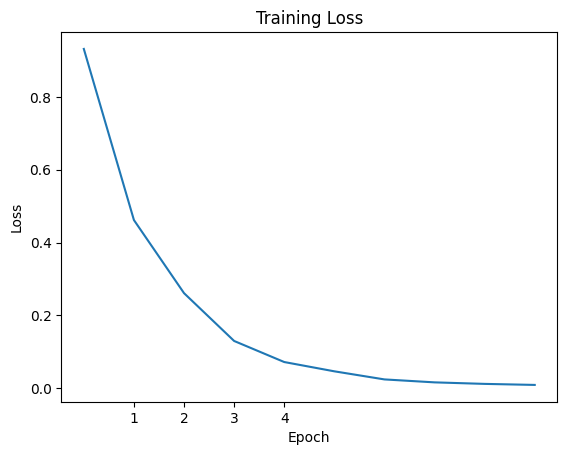

In [ ]:
df_stats = pd.DataFrame(data=training_stats)
plt.plot(df_stats['Training Loss'], label="Training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([1, 2, 3, 4])
plt.show()

In [ ]:
test_texts = test.text.values
test_labels = test.label.values

input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = max_len,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

batch_size = 32

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
print('Prediction started on test data')
model.eval()
predictions , true_labels, prdict_label = [], [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids,
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()


  predictions.append(logits)
  true_labels.append(label_ids)
  prdict_label.append(np.argmax(logits, axis=1).flatten())

print('Prediction completed')

Prediction started on test data
Prediction completed


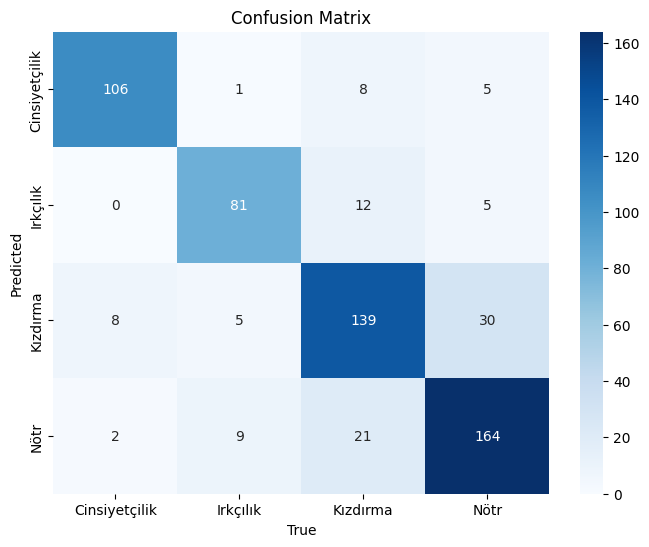

In [ ]:
true_labels_flat = [item for sublist in true_labels for item in sublist]
predicted_labels_flat = [item for sublist in prdict_label for item in sublist]

cm = confusion_matrix(true_labels_flat, predicted_labels_flat)


# Sınıf isimlerini belirle
class_names = ['Cinsiyetçilik', 'Irkçılık', 'Kızdırma', 'Nötr']

# Karışıklık matrisini görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

In [ ]:
f_score = f1_score(test_labels, prediction_scores, average='macro')
precision = precision_score(test_labels, prediction_scores, average='macro')
recall = recall_score(test_labels, prediction_scores, average='macro')
accr = accuracy_score(test_labels, prediction_scores)

In [ ]:
print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)
print("Accuracy: ", accr)

F-Score:  0.830328108060622
Recall:  0.8275837257980114
Precision:  0.8334217235744872
Accuracy:  0.8221476510067114


In [ ]:
report = pd.DataFrame(classification_report(test_labels, prediction_scores, output_dict=True))


In [ ]:
report = report.rename(columns={
                                '0':'Cinsiyetçilik',
                                '1':'Irkçılık',
                                '2':'Kızdırma',
                                '3':'Nötr'})
report

,Cinsiyetçilik,Irkçılık,Kızdırma,Nötr,accuracy,macro avg,weighted avg
precision,0.913793,0.843750,0.772222,0.803922,0.822148,0.833422,0.822912
recall,0.883333,0.826531,0.763736,0.836735,0.822148,0.827584,0.822148
f1-score,0.898305,0.835052,0.767956,0.820000,0.822148,0.830328,0.822348
support,120.000000,98.000000,182.000000,196.000000,0.822148,596.000000,596.000000


               precision    recall  f1-score   support

Cinsiyetçilik       0.91      0.88      0.90       120
     Irkçılık       0.84      0.83      0.84        98
     Kızdırma       0.77      0.76      0.77       182
         Nötr       0.80      0.84      0.82       196

     accuracy                           0.82       596
    macro avg       0.83      0.83      0.83       596
 weighted avg       0.82      0.82      0.82       596

                        Class Precision    Recall  F1 Score
0               Cinsiyetçilik  0.913793  0.883333  0.898305
1                    Irkçılık   0.84375  0.826531  0.835052
2                    Kızdırma  0.772222  0.763736  0.767956
3                        Nötr  0.803922  0.836735  0.820000
Average              Ortalama  0.833422  0.827584  0.830328
Total Accuracy                                     0.822148


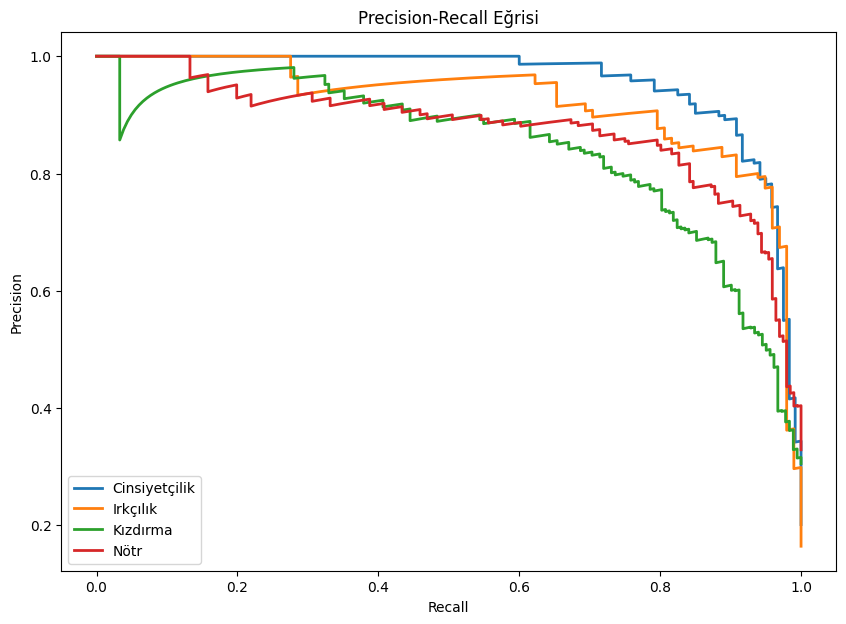

In [ ]:
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Sınıf bazında precision, recall, f1-score ve support değerlerini hesaplama
class_names = ['Cinsiyetçilik', 'Irkçılık', 'Kızdırma', 'Nötr']
print(classification_report(true_labels, np.argmax(predictions, axis=1), target_names=class_names))

# Precision-Recall eğrisi hesaplama
n_classes = predictions.shape[1]
precision = dict()
recall = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(true_labels == i, predictions[:, i])

# Metrikleri bir tablo halinde gösterme
precision_scores = precision_score(true_labels, np.argmax(predictions, axis=1), average=None)
recall_scores = recall_score(true_labels, np.argmax(predictions, axis=1), average=None)
f1_scores = f1_score(true_labels, np.argmax(predictions, axis=1), average=None)
accuracy = accuracy_score(true_labels, np.argmax(predictions, axis=1))

metrics_table = pd.DataFrame({
    'Class': class_names,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
})
metrics_table.loc['Average'] = ['Ortalama', precision_score(true_labels, np.argmax(predictions, axis=1), average='macro'),
                                recall_score(true_labels, np.argmax(predictions, axis=1), average='macro'),
                                f1_score(true_labels, np.argmax(predictions, axis=1), average='macro')]
metrics_table.loc['Total Accuracy'] = ['', '', '', accuracy]

print(metrics_table)

# PR eğrisini çizme
plt.figure(figsize=(10, 7))

for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=class_names[i])


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Eğrisi')
plt.legend(loc='best')
plt.show()


In [ ]:


# Metinler
texts = [
    "yalnız tam pikniklik hava ",
    "Aptal zihniyetinizde bir Yunan yatıyor",
    "maça giderken karısına soran adam maça gelmesin",
    "kör olası çöpçüler aşkımı süpürmüşler",
    "hala dünya klasiklerini okumamış cahillerle yaşıyorum",
    "ermenilerden her haltı beklerim",
    "seninle iyi anlaştık",
    "büte kalmamış erkek örgü örsün",
    "mühendisler bir halt bildiğini sananlar sürüsü",
    "sende bende ne dediğimizi bilmiyoruz",
    "çok cahil birisin",
    "bu hallerine acıyorum",
    "kızlar harici giremez",
    "kes sesini",
    "bu aralar iyiisn",
    "akiili erdogan!",
    "erdoğan abiye selam söyle",
    "Türkler çayı sever",
    "çok cahilsin",
    "çok cahil biri",
    "çok cahil birisin",
    "ikimizde ne dediğimizi bilmiyoruz",
    "seni gören de bir şey sanır"
]

# Model tahminleri
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, task="text-classification")
predictions = pipe(texts)

# Sınıf adları
class_names = {
    "LABEL_0": 'Cinsiyetçilik',
    "LABEL_1": 'Irkçılık',
    "LABEL_2": 'Kızdırma',
    "LABEL_3": 'Nötr'
}

# Tahmin sonuçlarını rapora dönüştürme
report = pd.DataFrame(predictions)
report['text'] = texts
report['label'] = report['label'].map(class_names)
report = report[['text', 'label', 'score']]

# Raporu yazdırma
print(report)

                                                 text          label     score
0                          yalnız tam pikniklik hava            Nötr  0.999756
1              Aptal zihniyetinizde bir Yunan yatıyor       Irkçılık  0.999470
2     maça giderken karısına soran adam maça gelmesin  Cinsiyetçilik  0.791150
3               kör olası çöpçüler aşkımı süpürmüşler       Kızdırma  0.998910
4   hala dünya klasiklerini okumamış cahillerle ya...       Kızdırma  0.944341
5                     ermenilerden her haltı beklerim       Irkçılık  0.999023
6                                seninle iyi anlaştık           Nötr  0.999766
7                      büte kalmamış erkek örgü örsün  Cinsiyetçilik  0.998323
8      mühendisler bir halt bildiğini sananlar sürüsü       Kızdırma  0.992588
9                sende bende ne dediğimizi bilmiyoruz           Nötr  0.999333
10                                  çok cahil birisin       Kızdırma  0.997530
11                              bu hallerine acıyoru

In [ ]:
tokenizer.save_pretrained("./distilbert-turkish-based-cyberbullyinG-tokenizer")
model.save_pretrained("./distilbert-turkish-based-cyberbullyinG-model")

In [ ]:
import shutil
# Model ve tokenizer dosyalarını Google Drive'a taşıma
shutil.move("./distilbert-turkish-based-cyberbullyinG-tokenizer", "/content/drive/My Drive/")
shutil.move("./distilbert-turkish-based-cyberbullyinG-model", "/content/drive/My Drive/")

'/content/drive/My Drive/distilbert-turkish-based-cyberbullyinG-model'